In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
%config InlineBackend.figure_format = 'retina'

In [1]:
'''
Set directory parameters
'''
# Set the directories for the data and the CSV files that contain ids/labels
dir_train_images  = './training/'
dir_test_images   = './testing/'
dir_train_labels  = './labels_training.csv'
dir_test_ids      = './sample_submission.csv'

In [112]:
'''
Include the functions used for loading, preprocessing, features extraction, 
classification, and performance evaluation
'''

def load_data(dir_data, dir_labels, training=True):
    ''' Load each of the image files into memory 

    While this is feasible with a smaller dataset, for larger datasets,
    not all the images would be able to be loaded into memory

    When training=True, the labels are also loaded
    '''
    labels_pd = pd.read_csv(dir_labels)
    ids       = labels_pd.id.values
    data      = []
    for identifier in ids:
        fname     = dir_data + identifier.astype(str) + '.tif'
        image     = mpl.image.imread(fname)
        data.append(image)
    data = np.array(data) # Convert to Numpy array
    if training:
        labels = labels_pd.label.values
        return data, labels
    else:
        return data, ids

def cv_performance_assessment(X,y,k,clf):
    '''Cross validated performance assessment
    
    X   = training data
    y   = training labels
    k   = number of folds for cross validation
    clf = classifier to use
    
    Divide the training data into k folds of training and validation data. 
    For each fold the classifier will be trained on the training data and
    tested on the validation data. The classifier prediction scores are 
    aggregated and output
    '''
    # Establish the k folds
    prediction_scores = np.empty(y.shape[0],dtype='object')
    kf = StratifiedKFold(n_splits=k, shuffle=True)
    fold = 0
    for train_index, val_index in kf.split(X, y):
        # Extract the training and validation data for this fold
        fold = fold + 1
        print('Starting fold: %s' % fold)
        X_train, X_val   = X.iloc[train_index], X.iloc[val_index]
        y_train          = y.iloc[train_index]
        
        # Train the classifier
        #X_train_features = preprocess_and_extract_features(X_train)
        clf              = clf.fit(X_train,y_train)
        
        # Test the classifier on the validation data for this fold
        #X_val_features   = preprocess_and_extract_features(X_val)
        cpred            = clf.predict_proba(X_val)
        
        # Save the predictions for this fold
        prediction_scores[val_index] = cpred[:,1]
    auc = metrics.roc_auc_score(y, prediction_scores)
    return prediction_scores,auc

def plot_roc(labels, prediction_scores):
    fpr, tpr, _ = metrics.roc_curve(labels, prediction_scores, pos_label=1)
    auc = metrics.roc_auc_score(labels, prediction_scores)
    legend_string = 'AUC = {:0.3f}'.format(auc)
   
    plt.plot([0,1],[0,1],'--', color='gray', label='Chance')
    plt.plot(fpr, tpr, label=legend_string)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.tight_layout()


In [26]:
from skimage.feature import hog
from skimage.color import rgb2gray

def create_features(img,create_greyscale = True,create_hog = True):
    hog_features = None
    grey_image = None
    
    #Check if to create grey scale
    if create_greyscale == True:
        # convert image to greyscale
        grey_image = rgb2gray(img)
        grey_image = grey_image.flatten()
    if create_hog == True:
        # get HOG features from image
        hog_features = hog(img, orientations=9, pixels_per_cell=(8, 8),block_norm='L2-Hys',
                    cells_per_block=(2, 2), visualize=False, multichannel=True)    
    return hog_features,grey_image

def create_feature_matrix(images,create_greyscale = True,create_hog = True):
    features_list = []
    grey_images = []
    for img_id in range(images.shape[0]):
        if img_id in [0,1000,10000,30000,50000,70000,100000]:
            print('Starting HOG for image: %s' % (img_id))
            pass
        
        # load image
        img = images[img_id]
        # get features for image
        image_features,grey_image = create_features(img,create_greyscale,create_hog)
        features_list.append(image_features)
        grey_images.append(grey_image)
        if img_id in [0,250,500,1000,1250,10000,30000,50000,70000,100000]:
            print('Completed HOG for image: %s' % (img_id))
            pass
        
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    grey_image_matrix = np.array(grey_images)
    return feature_matrix, grey_image_matrix

In [7]:
images, labels = load_data(dir_train_images, dir_train_labels, training=True)

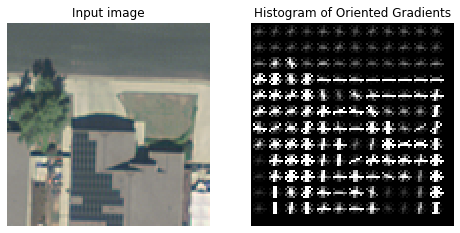

In [12]:
from skimage import exposure

fname     = dir_train_images + '2' + '.tif'
image     = mpl.image.imread(fname)


fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [30]:
hog_original_features, grey_images_original = create_feature_matrix(images)

Starting HOG for image: 0
Completed HOG for image: 0
Completed HOG for image: 250
Completed HOG for image: 500
Starting HOG for image: 1000
Completed HOG for image: 1000
Completed HOG for image: 1250


In [28]:
grey_images_original.shape

(1500, 10201)

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# get shape of feature matrix
print('Feature matrix shape is: ', grey_images_original.shape)

# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
solar_stand = ss.fit_transform(grey_images_original)

pca_2 = PCA(n_components=2)
pca_full = PCA(n_components=500)

# use fit_transform to run PCA on our standardized matrix
solar_pca_2 = pca_2.fit_transform(solar_stand)
solar_pca_full = pca_full.fit_transform(solar_stand)
# look at new shape
print('PCA matrix shape is: ', solar_pca.shape)

Feature matrix shape is:  (1500, 10201)
PCA matrix shape is:  (1500, 2)


In [57]:
#print(pca.explained_variance_ratio_)
np.sum(pca_full.explained_variance_ratio_)

0.9332442435576052

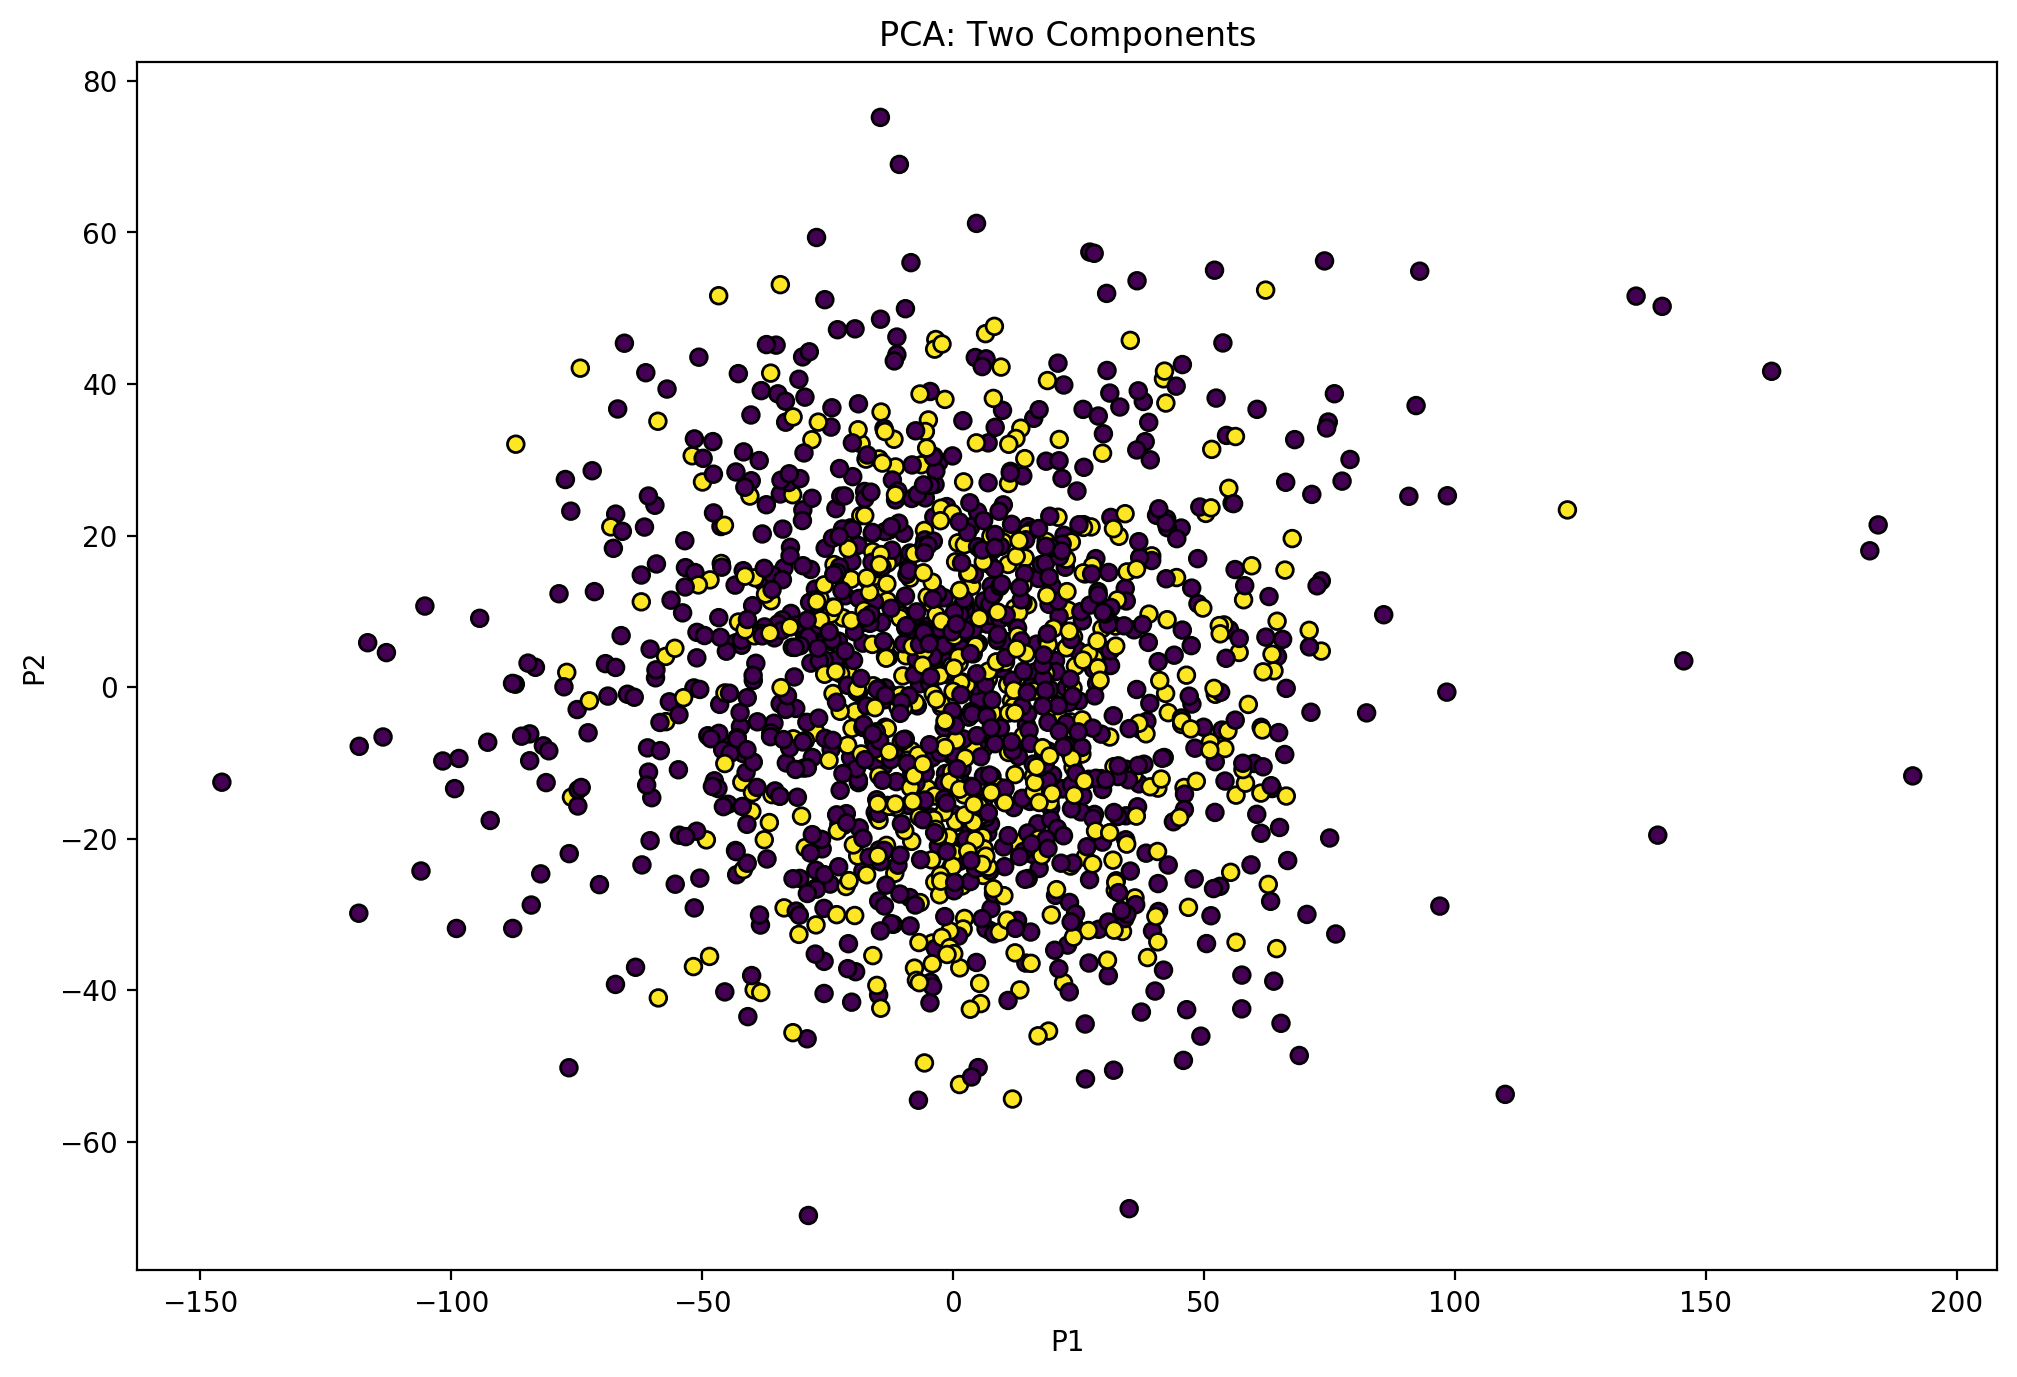

In [75]:
plt.figure(figsize=(12,8), dpi= 100)
plt.scatter(x=solar_pca[:,0],y=solar_pca[:,1],c=labels,edgecolor='k')
plt.title("PCA: Two Components")
plt.xlabel("P1")
plt.ylabel("P2")
plt.show()

In [101]:
X.index

RangeIndex(start=0, stop=1500, step=1)

In [118]:
X = pd.DataFrame(solar_pca_full)
y = pd.Series(labels)
X_train_hog_pca, X_val_hog_pca, y_train_hog_pca, y_val_hog_pca = train_test_split(X,
                                                    y,
                                                    test_size=.1,
                                                    shuffle = True,
                                                    random_state=1234123)

X_hog_full_train = pd.DataFrame(hog_original_features)
X_train_hog, X_val_hog, y_train_hog, y_val_hog = train_test_split(X_hog_full_train,
                                                    y,
                                                    test_size=.2,
                                                    shuffle = True,
                                                    random_state=1234123)

# look at the distrubution of labels in the train set
pd.Series(y_train_hog_pca).value_counts()

0    895
1    455
dtype: int64

Starting fold: 1
Starting fold: 2
Starting fold: 3
Starting fold: 4
Starting fold: 5


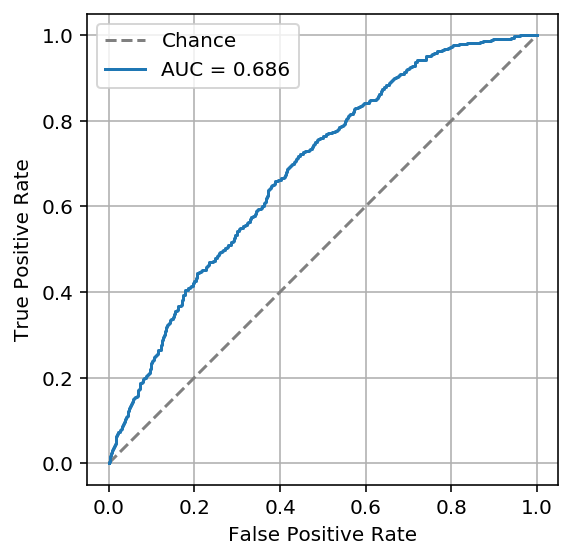

In [113]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier

hgbc_ml_hog_pca = HistGradientBoostingClassifier(loss='binary_crossentropy')

hgbc_cv_prediction_scores,hgbc_auc_cv = cv_performance_assessment(X, y,5,hgbc_ml_hog_pca)
plot_roc(labels, hgbc_cv_prediction_scores)

In [60]:
hgbc_ml_hog_pca.score(X_train_hog_pca, y_train_hog_pca)

1.0

In [61]:
hgbc_ml_hog_pca.score(X_val_hog_pca, y_val_hog_pca)

0.6826666666666666

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
gbc_ml_hog_pca = GradientBoostingClassifier().fit(X_train_hog_pca, y_train_hog_pca)

In [29]:
gbc_ml_hog_pca.score(X_train_hog_pca, y_train_hog_pca)

0.693010101010101

In [30]:
gbc_ml_hog_pca.score(X_val_hog_pca, y_val_hog_pca)

0.6584242424242425

In [88]:
import pandas as pd

learning_rates = [1, 0.5, 0.1]
n_estimators = [64, 100, 500,1000]
max_depths = [1,3,5,100]
min_samples_splits = [2,100,500]
min_samples_leafs = [1,100,500]
max_features = [100,1000,10000,hog_original_images.shape[1]]

results_df = pd.DataFrame({'learning_rates' : [],
                             'n_estimators' : [],
                             'max_depths' : [],
                             'min_samples_splits' : [],
                             'min_samples_leafs' : [],
                             'max_features' : [],
                             'test_auc' : []
                          })

for learning_rate in learning_rates:
    for n_estimator in n_estimators:
        for max_depth in max_depths:
            for min_samples_split in min_samples_splits:
                for min_samples_leaf in min_samples_leafs:
                    for max_feature in max_features:
                        print('Starting iteration with learning_rate=%s, n_estimator=%s, max_depth=%s, min_samples_split = %s,min_samples_leaf=%s,max_feature=%s' % (learning_rate, n_estimator, max_depth, min_samples_split,min_samples_leaf,max_feature))
                        gbc_ml_cv_hog_original = GradientBoostingClassifier(learning_rate=learning_rate, 
                                                                            n_estimators=n_estimator, 
                                                                            min_samples_split=min_samples_split, 
                                                                            min_samples_leaf=min_samples_leaf, 
                                                                            max_depth=max_depth,
                                                                            max_features=max_feature, 
                                                                            verbose=0, 
                                                                            warm_start=True, 
                                                                            n_iter_no_change=5)
                        
                        gbc_ml_cv_hog_original.fit(hog_original_images, labels)
                        gbc_cv_prediction_scores = gbc_ml_cv_hog_original.predict_proba(hog_original_images)
                        auc = metrics.roc_auc_score(labels, gbc_cv_prediction_scores[:,1])
                        results_df = results_df.append({'learning_rate' : learning_rate,
                                                         'n_estimator' : n_estimator,
                                                         'max_depths' : max_depth,
                                                         'min_samples_splits' : min_samples_split,
                                                         'min_samples_leafs' : min_samples_leaf,
                                                         'max_features' : max_feature,
                                                         'test_auc' : auc
                                                        }, ignore_index=True)

Starting iteration with learning_rate=1, n_estimator=64, max_depth=1, min_samples_split = 2,min_samples_leaf=1,max_feature=100
Starting iteration with learning_rate=1, n_estimator=64, max_depth=1, min_samples_split = 2,min_samples_leaf=1,max_feature=1000
Starting iteration with learning_rate=1, n_estimator=64, max_depth=1, min_samples_split = 2,min_samples_leaf=1,max_feature=10000
Starting iteration with learning_rate=1, n_estimator=64, max_depth=1, min_samples_split = 2,min_samples_leaf=1,max_feature=30603
Starting iteration with learning_rate=1, n_estimator=64, max_depth=1, min_samples_split = 2,min_samples_leaf=100,max_feature=100
Starting iteration with learning_rate=1, n_estimator=64, max_depth=1, min_samples_split = 2,min_samples_leaf=100,max_feature=1000
Starting iteration with learning_rate=1, n_estimator=64, max_depth=1, min_samples_split = 2,min_samples_leaf=100,max_feature=10000
Starting iteration with learning_rate=1, n_estimator=64, max_depth=1, min_samples_split = 2,min_s

Starting iteration with learning_rate=1, n_estimator=64, max_depth=3, min_samples_split = 500,min_samples_leaf=1,max_feature=30603
Starting iteration with learning_rate=1, n_estimator=64, max_depth=3, min_samples_split = 500,min_samples_leaf=100,max_feature=100
Starting iteration with learning_rate=1, n_estimator=64, max_depth=3, min_samples_split = 500,min_samples_leaf=100,max_feature=1000
Starting iteration with learning_rate=1, n_estimator=64, max_depth=3, min_samples_split = 500,min_samples_leaf=100,max_feature=10000
Starting iteration with learning_rate=1, n_estimator=64, max_depth=3, min_samples_split = 500,min_samples_leaf=100,max_feature=30603
Starting iteration with learning_rate=1, n_estimator=64, max_depth=3, min_samples_split = 500,min_samples_leaf=500,max_feature=100
Starting iteration with learning_rate=1, n_estimator=64, max_depth=3, min_samples_split = 500,min_samples_leaf=500,max_feature=1000
Starting iteration with learning_rate=1, n_estimator=64, max_depth=3, min_sam

Starting iteration with learning_rate=1, n_estimator=64, max_depth=100, min_samples_split = 100,min_samples_leaf=100,max_feature=10000
Starting iteration with learning_rate=1, n_estimator=64, max_depth=100, min_samples_split = 100,min_samples_leaf=100,max_feature=30603
Starting iteration with learning_rate=1, n_estimator=64, max_depth=100, min_samples_split = 100,min_samples_leaf=500,max_feature=100
Starting iteration with learning_rate=1, n_estimator=64, max_depth=100, min_samples_split = 100,min_samples_leaf=500,max_feature=1000
Starting iteration with learning_rate=1, n_estimator=64, max_depth=100, min_samples_split = 100,min_samples_leaf=500,max_feature=10000
Starting iteration with learning_rate=1, n_estimator=64, max_depth=100, min_samples_split = 100,min_samples_leaf=500,max_feature=30603
Starting iteration with learning_rate=1, n_estimator=64, max_depth=100, min_samples_split = 500,min_samples_leaf=1,max_feature=100
Starting iteration with learning_rate=1, n_estimator=64, max_d

Starting iteration with learning_rate=1, n_estimator=100, max_depth=3, min_samples_split = 2,min_samples_leaf=500,max_feature=100
Starting iteration with learning_rate=1, n_estimator=100, max_depth=3, min_samples_split = 2,min_samples_leaf=500,max_feature=1000
Starting iteration with learning_rate=1, n_estimator=100, max_depth=3, min_samples_split = 2,min_samples_leaf=500,max_feature=10000
Starting iteration with learning_rate=1, n_estimator=100, max_depth=3, min_samples_split = 2,min_samples_leaf=500,max_feature=30603
Starting iteration with learning_rate=1, n_estimator=100, max_depth=3, min_samples_split = 100,min_samples_leaf=1,max_feature=100
Starting iteration with learning_rate=1, n_estimator=100, max_depth=3, min_samples_split = 100,min_samples_leaf=1,max_feature=1000
Starting iteration with learning_rate=1, n_estimator=100, max_depth=3, min_samples_split = 100,min_samples_leaf=1,max_feature=10000
Starting iteration with learning_rate=1, n_estimator=100, max_depth=3, min_samples

Starting iteration with learning_rate=1, n_estimator=100, max_depth=5, min_samples_split = 500,min_samples_leaf=500,max_feature=30603
Starting iteration with learning_rate=1, n_estimator=100, max_depth=100, min_samples_split = 2,min_samples_leaf=1,max_feature=100
Starting iteration with learning_rate=1, n_estimator=100, max_depth=100, min_samples_split = 2,min_samples_leaf=1,max_feature=1000
Starting iteration with learning_rate=1, n_estimator=100, max_depth=100, min_samples_split = 2,min_samples_leaf=1,max_feature=10000
Starting iteration with learning_rate=1, n_estimator=100, max_depth=100, min_samples_split = 2,min_samples_leaf=1,max_feature=30603
Starting iteration with learning_rate=1, n_estimator=100, max_depth=100, min_samples_split = 2,min_samples_leaf=100,max_feature=100
Starting iteration with learning_rate=1, n_estimator=100, max_depth=100, min_samples_split = 2,min_samples_leaf=100,max_feature=1000
Starting iteration with learning_rate=1, n_estimator=100, max_depth=100, min

Starting iteration with learning_rate=1, n_estimator=500, max_depth=1, min_samples_split = 500,min_samples_leaf=1,max_feature=1000
Starting iteration with learning_rate=1, n_estimator=500, max_depth=1, min_samples_split = 500,min_samples_leaf=1,max_feature=10000
Starting iteration with learning_rate=1, n_estimator=500, max_depth=1, min_samples_split = 500,min_samples_leaf=1,max_feature=30603
Starting iteration with learning_rate=1, n_estimator=500, max_depth=1, min_samples_split = 500,min_samples_leaf=100,max_feature=100
Starting iteration with learning_rate=1, n_estimator=500, max_depth=1, min_samples_split = 500,min_samples_leaf=100,max_feature=1000
Starting iteration with learning_rate=1, n_estimator=500, max_depth=1, min_samples_split = 500,min_samples_leaf=100,max_feature=10000
Starting iteration with learning_rate=1, n_estimator=500, max_depth=1, min_samples_split = 500,min_samples_leaf=100,max_feature=30603
Starting iteration with learning_rate=1, n_estimator=500, max_depth=1, m

Starting iteration with learning_rate=1, n_estimator=500, max_depth=5, min_samples_split = 100,min_samples_leaf=100,max_feature=100
Starting iteration with learning_rate=1, n_estimator=500, max_depth=5, min_samples_split = 100,min_samples_leaf=100,max_feature=1000
Starting iteration with learning_rate=1, n_estimator=500, max_depth=5, min_samples_split = 100,min_samples_leaf=100,max_feature=10000
Starting iteration with learning_rate=1, n_estimator=500, max_depth=5, min_samples_split = 100,min_samples_leaf=100,max_feature=30603
Starting iteration with learning_rate=1, n_estimator=500, max_depth=5, min_samples_split = 100,min_samples_leaf=500,max_feature=100
Starting iteration with learning_rate=1, n_estimator=500, max_depth=5, min_samples_split = 100,min_samples_leaf=500,max_feature=1000
Starting iteration with learning_rate=1, n_estimator=500, max_depth=5, min_samples_split = 100,min_samples_leaf=500,max_feature=10000
Starting iteration with learning_rate=1, n_estimator=500, max_depth=

Starting iteration with learning_rate=1, n_estimator=1000, max_depth=1, min_samples_split = 2,min_samples_leaf=100,max_feature=10000
Starting iteration with learning_rate=1, n_estimator=1000, max_depth=1, min_samples_split = 2,min_samples_leaf=100,max_feature=30603
Starting iteration with learning_rate=1, n_estimator=1000, max_depth=1, min_samples_split = 2,min_samples_leaf=500,max_feature=100
Starting iteration with learning_rate=1, n_estimator=1000, max_depth=1, min_samples_split = 2,min_samples_leaf=500,max_feature=1000
Starting iteration with learning_rate=1, n_estimator=1000, max_depth=1, min_samples_split = 2,min_samples_leaf=500,max_feature=10000
Starting iteration with learning_rate=1, n_estimator=1000, max_depth=1, min_samples_split = 2,min_samples_leaf=500,max_feature=30603
Starting iteration with learning_rate=1, n_estimator=1000, max_depth=1, min_samples_split = 100,min_samples_leaf=1,max_feature=100
Starting iteration with learning_rate=1, n_estimator=1000, max_depth=1, mi

Starting iteration with learning_rate=1, n_estimator=1000, max_depth=3, min_samples_split = 500,min_samples_leaf=500,max_feature=100
Starting iteration with learning_rate=1, n_estimator=1000, max_depth=3, min_samples_split = 500,min_samples_leaf=500,max_feature=1000
Starting iteration with learning_rate=1, n_estimator=1000, max_depth=3, min_samples_split = 500,min_samples_leaf=500,max_feature=10000
Starting iteration with learning_rate=1, n_estimator=1000, max_depth=3, min_samples_split = 500,min_samples_leaf=500,max_feature=30603
Starting iteration with learning_rate=1, n_estimator=1000, max_depth=5, min_samples_split = 2,min_samples_leaf=1,max_feature=100
Starting iteration with learning_rate=1, n_estimator=1000, max_depth=5, min_samples_split = 2,min_samples_leaf=1,max_feature=1000
Starting iteration with learning_rate=1, n_estimator=1000, max_depth=5, min_samples_split = 2,min_samples_leaf=1,max_feature=10000
Starting iteration with learning_rate=1, n_estimator=1000, max_depth=5, m

Starting iteration with learning_rate=1, n_estimator=1000, max_depth=100, min_samples_split = 100,min_samples_leaf=500,max_feature=10000
Starting iteration with learning_rate=1, n_estimator=1000, max_depth=100, min_samples_split = 100,min_samples_leaf=500,max_feature=30603
Starting iteration with learning_rate=1, n_estimator=1000, max_depth=100, min_samples_split = 500,min_samples_leaf=1,max_feature=100
Starting iteration with learning_rate=1, n_estimator=1000, max_depth=100, min_samples_split = 500,min_samples_leaf=1,max_feature=1000
Starting iteration with learning_rate=1, n_estimator=1000, max_depth=100, min_samples_split = 500,min_samples_leaf=1,max_feature=10000
Starting iteration with learning_rate=1, n_estimator=1000, max_depth=100, min_samples_split = 500,min_samples_leaf=1,max_feature=30603
Starting iteration with learning_rate=1, n_estimator=1000, max_depth=100, min_samples_split = 500,min_samples_leaf=100,max_feature=100
Starting iteration with learning_rate=1, n_estimator=1

Starting iteration with learning_rate=0.5, n_estimator=64, max_depth=3, min_samples_split = 100,min_samples_leaf=1,max_feature=100
Starting iteration with learning_rate=0.5, n_estimator=64, max_depth=3, min_samples_split = 100,min_samples_leaf=1,max_feature=1000
Starting iteration with learning_rate=0.5, n_estimator=64, max_depth=3, min_samples_split = 100,min_samples_leaf=1,max_feature=10000
Starting iteration with learning_rate=0.5, n_estimator=64, max_depth=3, min_samples_split = 100,min_samples_leaf=1,max_feature=30603
Starting iteration with learning_rate=0.5, n_estimator=64, max_depth=3, min_samples_split = 100,min_samples_leaf=100,max_feature=100
Starting iteration with learning_rate=0.5, n_estimator=64, max_depth=3, min_samples_split = 100,min_samples_leaf=100,max_feature=1000
Starting iteration with learning_rate=0.5, n_estimator=64, max_depth=3, min_samples_split = 100,min_samples_leaf=100,max_feature=10000
Starting iteration with learning_rate=0.5, n_estimator=64, max_depth=

Starting iteration with learning_rate=0.5, n_estimator=64, max_depth=100, min_samples_split = 2,min_samples_leaf=1,max_feature=10000
Starting iteration with learning_rate=0.5, n_estimator=64, max_depth=100, min_samples_split = 2,min_samples_leaf=1,max_feature=30603
Starting iteration with learning_rate=0.5, n_estimator=64, max_depth=100, min_samples_split = 2,min_samples_leaf=100,max_feature=100
Starting iteration with learning_rate=0.5, n_estimator=64, max_depth=100, min_samples_split = 2,min_samples_leaf=100,max_feature=1000
Starting iteration with learning_rate=0.5, n_estimator=64, max_depth=100, min_samples_split = 2,min_samples_leaf=100,max_feature=10000
Starting iteration with learning_rate=0.5, n_estimator=64, max_depth=100, min_samples_split = 2,min_samples_leaf=100,max_feature=30603
Starting iteration with learning_rate=0.5, n_estimator=64, max_depth=100, min_samples_split = 2,min_samples_leaf=500,max_feature=100
Starting iteration with learning_rate=0.5, n_estimator=64, max_d

Starting iteration with learning_rate=0.5, n_estimator=100, max_depth=1, min_samples_split = 500,min_samples_leaf=1,max_feature=30603
Starting iteration with learning_rate=0.5, n_estimator=100, max_depth=1, min_samples_split = 500,min_samples_leaf=100,max_feature=100
Starting iteration with learning_rate=0.5, n_estimator=100, max_depth=1, min_samples_split = 500,min_samples_leaf=100,max_feature=1000
Starting iteration with learning_rate=0.5, n_estimator=100, max_depth=1, min_samples_split = 500,min_samples_leaf=100,max_feature=10000
Starting iteration with learning_rate=0.5, n_estimator=100, max_depth=1, min_samples_split = 500,min_samples_leaf=100,max_feature=30603
Starting iteration with learning_rate=0.5, n_estimator=100, max_depth=1, min_samples_split = 500,min_samples_leaf=500,max_feature=100
Starting iteration with learning_rate=0.5, n_estimator=100, max_depth=1, min_samples_split = 500,min_samples_leaf=500,max_feature=1000
Starting iteration with learning_rate=0.5, n_estimator=1

Starting iteration with learning_rate=0.5, n_estimator=100, max_depth=5, min_samples_split = 100,min_samples_leaf=100,max_feature=1000
Starting iteration with learning_rate=0.5, n_estimator=100, max_depth=5, min_samples_split = 100,min_samples_leaf=100,max_feature=10000
Starting iteration with learning_rate=0.5, n_estimator=100, max_depth=5, min_samples_split = 100,min_samples_leaf=100,max_feature=30603
Starting iteration with learning_rate=0.5, n_estimator=100, max_depth=5, min_samples_split = 100,min_samples_leaf=500,max_feature=100
Starting iteration with learning_rate=0.5, n_estimator=100, max_depth=5, min_samples_split = 100,min_samples_leaf=500,max_feature=1000
Starting iteration with learning_rate=0.5, n_estimator=100, max_depth=5, min_samples_split = 100,min_samples_leaf=500,max_feature=10000
Starting iteration with learning_rate=0.5, n_estimator=100, max_depth=5, min_samples_split = 100,min_samples_leaf=500,max_feature=30603
Starting iteration with learning_rate=0.5, n_estimat

Starting iteration with learning_rate=0.5, n_estimator=500, max_depth=1, min_samples_split = 2,min_samples_leaf=100,max_feature=10000
Starting iteration with learning_rate=0.5, n_estimator=500, max_depth=1, min_samples_split = 2,min_samples_leaf=100,max_feature=30603
Starting iteration with learning_rate=0.5, n_estimator=500, max_depth=1, min_samples_split = 2,min_samples_leaf=500,max_feature=100
Starting iteration with learning_rate=0.5, n_estimator=500, max_depth=1, min_samples_split = 2,min_samples_leaf=500,max_feature=1000
Starting iteration with learning_rate=0.5, n_estimator=500, max_depth=1, min_samples_split = 2,min_samples_leaf=500,max_feature=10000
Starting iteration with learning_rate=0.5, n_estimator=500, max_depth=1, min_samples_split = 2,min_samples_leaf=500,max_feature=30603
Starting iteration with learning_rate=0.5, n_estimator=500, max_depth=1, min_samples_split = 100,min_samples_leaf=1,max_feature=100
Starting iteration with learning_rate=0.5, n_estimator=500, max_dep

Starting iteration with learning_rate=0.5, n_estimator=500, max_depth=3, min_samples_split = 500,min_samples_leaf=500,max_feature=100
Starting iteration with learning_rate=0.5, n_estimator=500, max_depth=3, min_samples_split = 500,min_samples_leaf=500,max_feature=1000
Starting iteration with learning_rate=0.5, n_estimator=500, max_depth=3, min_samples_split = 500,min_samples_leaf=500,max_feature=10000
Starting iteration with learning_rate=0.5, n_estimator=500, max_depth=3, min_samples_split = 500,min_samples_leaf=500,max_feature=30603
Starting iteration with learning_rate=0.5, n_estimator=500, max_depth=5, min_samples_split = 2,min_samples_leaf=1,max_feature=100
Starting iteration with learning_rate=0.5, n_estimator=500, max_depth=5, min_samples_split = 2,min_samples_leaf=1,max_feature=1000
Starting iteration with learning_rate=0.5, n_estimator=500, max_depth=5, min_samples_split = 2,min_samples_leaf=1,max_feature=10000
Starting iteration with learning_rate=0.5, n_estimator=500, max_de

Starting iteration with learning_rate=0.5, n_estimator=500, max_depth=100, min_samples_split = 100,min_samples_leaf=500,max_feature=1000
Starting iteration with learning_rate=0.5, n_estimator=500, max_depth=100, min_samples_split = 100,min_samples_leaf=500,max_feature=10000
Starting iteration with learning_rate=0.5, n_estimator=500, max_depth=100, min_samples_split = 100,min_samples_leaf=500,max_feature=30603
Starting iteration with learning_rate=0.5, n_estimator=500, max_depth=100, min_samples_split = 500,min_samples_leaf=1,max_feature=100
Starting iteration with learning_rate=0.5, n_estimator=500, max_depth=100, min_samples_split = 500,min_samples_leaf=1,max_feature=1000
Starting iteration with learning_rate=0.5, n_estimator=500, max_depth=100, min_samples_split = 500,min_samples_leaf=1,max_feature=10000
Starting iteration with learning_rate=0.5, n_estimator=500, max_depth=100, min_samples_split = 500,min_samples_leaf=1,max_feature=30603
Starting iteration with learning_rate=0.5, n_e

Starting iteration with learning_rate=0.5, n_estimator=1000, max_depth=3, min_samples_split = 2,min_samples_leaf=500,max_feature=10000
Starting iteration with learning_rate=0.5, n_estimator=1000, max_depth=3, min_samples_split = 2,min_samples_leaf=500,max_feature=30603
Starting iteration with learning_rate=0.5, n_estimator=1000, max_depth=3, min_samples_split = 100,min_samples_leaf=1,max_feature=100
Starting iteration with learning_rate=0.5, n_estimator=1000, max_depth=3, min_samples_split = 100,min_samples_leaf=1,max_feature=1000
Starting iteration with learning_rate=0.5, n_estimator=1000, max_depth=3, min_samples_split = 100,min_samples_leaf=1,max_feature=10000
Starting iteration with learning_rate=0.5, n_estimator=1000, max_depth=3, min_samples_split = 100,min_samples_leaf=1,max_feature=30603
Starting iteration with learning_rate=0.5, n_estimator=1000, max_depth=3, min_samples_split = 100,min_samples_leaf=100,max_feature=100
Starting iteration with learning_rate=0.5, n_estimator=100

Starting iteration with learning_rate=0.5, n_estimator=1000, max_depth=5, min_samples_split = 500,min_samples_leaf=500,max_feature=30603
Starting iteration with learning_rate=0.5, n_estimator=1000, max_depth=100, min_samples_split = 2,min_samples_leaf=1,max_feature=100
Starting iteration with learning_rate=0.5, n_estimator=1000, max_depth=100, min_samples_split = 2,min_samples_leaf=1,max_feature=1000
Starting iteration with learning_rate=0.5, n_estimator=1000, max_depth=100, min_samples_split = 2,min_samples_leaf=1,max_feature=10000
Starting iteration with learning_rate=0.5, n_estimator=1000, max_depth=100, min_samples_split = 2,min_samples_leaf=1,max_feature=30603
Starting iteration with learning_rate=0.5, n_estimator=1000, max_depth=100, min_samples_split = 2,min_samples_leaf=100,max_feature=100
Starting iteration with learning_rate=0.5, n_estimator=1000, max_depth=100, min_samples_split = 2,min_samples_leaf=100,max_feature=1000
Starting iteration with learning_rate=0.5, n_estimator=

Starting iteration with learning_rate=0.1, n_estimator=64, max_depth=1, min_samples_split = 500,min_samples_leaf=1,max_feature=100
Starting iteration with learning_rate=0.1, n_estimator=64, max_depth=1, min_samples_split = 500,min_samples_leaf=1,max_feature=1000
Starting iteration with learning_rate=0.1, n_estimator=64, max_depth=1, min_samples_split = 500,min_samples_leaf=1,max_feature=10000
Starting iteration with learning_rate=0.1, n_estimator=64, max_depth=1, min_samples_split = 500,min_samples_leaf=1,max_feature=30603
Starting iteration with learning_rate=0.1, n_estimator=64, max_depth=1, min_samples_split = 500,min_samples_leaf=100,max_feature=100
Starting iteration with learning_rate=0.1, n_estimator=64, max_depth=1, min_samples_split = 500,min_samples_leaf=100,max_feature=1000
Starting iteration with learning_rate=0.1, n_estimator=64, max_depth=1, min_samples_split = 500,min_samples_leaf=100,max_feature=10000
Starting iteration with learning_rate=0.1, n_estimator=64, max_depth=

Starting iteration with learning_rate=0.1, n_estimator=64, max_depth=5, min_samples_split = 100,min_samples_leaf=1,max_feature=10000
Starting iteration with learning_rate=0.1, n_estimator=64, max_depth=5, min_samples_split = 100,min_samples_leaf=1,max_feature=30603
Starting iteration with learning_rate=0.1, n_estimator=64, max_depth=5, min_samples_split = 100,min_samples_leaf=100,max_feature=100
Starting iteration with learning_rate=0.1, n_estimator=64, max_depth=5, min_samples_split = 100,min_samples_leaf=100,max_feature=1000
Starting iteration with learning_rate=0.1, n_estimator=64, max_depth=5, min_samples_split = 100,min_samples_leaf=100,max_feature=10000
Starting iteration with learning_rate=0.1, n_estimator=64, max_depth=5, min_samples_split = 100,min_samples_leaf=100,max_feature=30603
Starting iteration with learning_rate=0.1, n_estimator=64, max_depth=5, min_samples_split = 100,min_samples_leaf=500,max_feature=100
Starting iteration with learning_rate=0.1, n_estimator=64, max_d

Starting iteration with learning_rate=0.1, n_estimator=100, max_depth=1, min_samples_split = 2,min_samples_leaf=1,max_feature=30603
Starting iteration with learning_rate=0.1, n_estimator=100, max_depth=1, min_samples_split = 2,min_samples_leaf=100,max_feature=100
Starting iteration with learning_rate=0.1, n_estimator=100, max_depth=1, min_samples_split = 2,min_samples_leaf=100,max_feature=1000
Starting iteration with learning_rate=0.1, n_estimator=100, max_depth=1, min_samples_split = 2,min_samples_leaf=100,max_feature=10000
Starting iteration with learning_rate=0.1, n_estimator=100, max_depth=1, min_samples_split = 2,min_samples_leaf=100,max_feature=30603
Starting iteration with learning_rate=0.1, n_estimator=100, max_depth=1, min_samples_split = 2,min_samples_leaf=500,max_feature=100
Starting iteration with learning_rate=0.1, n_estimator=100, max_depth=1, min_samples_split = 2,min_samples_leaf=500,max_feature=1000
Starting iteration with learning_rate=0.1, n_estimator=100, max_depth=

Starting iteration with learning_rate=0.1, n_estimator=100, max_depth=3, min_samples_split = 500,min_samples_leaf=100,max_feature=1000
Starting iteration with learning_rate=0.1, n_estimator=100, max_depth=3, min_samples_split = 500,min_samples_leaf=100,max_feature=10000
Starting iteration with learning_rate=0.1, n_estimator=100, max_depth=3, min_samples_split = 500,min_samples_leaf=100,max_feature=30603
Starting iteration with learning_rate=0.1, n_estimator=100, max_depth=3, min_samples_split = 500,min_samples_leaf=500,max_feature=100
Starting iteration with learning_rate=0.1, n_estimator=100, max_depth=3, min_samples_split = 500,min_samples_leaf=500,max_feature=1000
Starting iteration with learning_rate=0.1, n_estimator=100, max_depth=3, min_samples_split = 500,min_samples_leaf=500,max_feature=10000
Starting iteration with learning_rate=0.1, n_estimator=100, max_depth=3, min_samples_split = 500,min_samples_leaf=500,max_feature=30603
Starting iteration with learning_rate=0.1, n_estimat

Starting iteration with learning_rate=0.1, n_estimator=100, max_depth=100, min_samples_split = 100,min_samples_leaf=100,max_feature=10000
Starting iteration with learning_rate=0.1, n_estimator=100, max_depth=100, min_samples_split = 100,min_samples_leaf=100,max_feature=30603
Starting iteration with learning_rate=0.1, n_estimator=100, max_depth=100, min_samples_split = 100,min_samples_leaf=500,max_feature=100
Starting iteration with learning_rate=0.1, n_estimator=100, max_depth=100, min_samples_split = 100,min_samples_leaf=500,max_feature=1000
Starting iteration with learning_rate=0.1, n_estimator=100, max_depth=100, min_samples_split = 100,min_samples_leaf=500,max_feature=10000
Starting iteration with learning_rate=0.1, n_estimator=100, max_depth=100, min_samples_split = 100,min_samples_leaf=500,max_feature=30603
Starting iteration with learning_rate=0.1, n_estimator=100, max_depth=100, min_samples_split = 500,min_samples_leaf=1,max_feature=100
Starting iteration with learning_rate=0.1

Starting iteration with learning_rate=0.1, n_estimator=500, max_depth=3, min_samples_split = 2,min_samples_leaf=100,max_feature=30603
Starting iteration with learning_rate=0.1, n_estimator=500, max_depth=3, min_samples_split = 2,min_samples_leaf=500,max_feature=100
Starting iteration with learning_rate=0.1, n_estimator=500, max_depth=3, min_samples_split = 2,min_samples_leaf=500,max_feature=1000
Starting iteration with learning_rate=0.1, n_estimator=500, max_depth=3, min_samples_split = 2,min_samples_leaf=500,max_feature=10000
Starting iteration with learning_rate=0.1, n_estimator=500, max_depth=3, min_samples_split = 2,min_samples_leaf=500,max_feature=30603
Starting iteration with learning_rate=0.1, n_estimator=500, max_depth=3, min_samples_split = 100,min_samples_leaf=1,max_feature=100
Starting iteration with learning_rate=0.1, n_estimator=500, max_depth=3, min_samples_split = 100,min_samples_leaf=1,max_feature=1000
Starting iteration with learning_rate=0.1, n_estimator=500, max_dept

Starting iteration with learning_rate=0.1, n_estimator=500, max_depth=5, min_samples_split = 500,min_samples_leaf=500,max_feature=1000
Starting iteration with learning_rate=0.1, n_estimator=500, max_depth=5, min_samples_split = 500,min_samples_leaf=500,max_feature=10000
Starting iteration with learning_rate=0.1, n_estimator=500, max_depth=5, min_samples_split = 500,min_samples_leaf=500,max_feature=30603
Starting iteration with learning_rate=0.1, n_estimator=500, max_depth=100, min_samples_split = 2,min_samples_leaf=1,max_feature=100
Starting iteration with learning_rate=0.1, n_estimator=500, max_depth=100, min_samples_split = 2,min_samples_leaf=1,max_feature=1000
Starting iteration with learning_rate=0.1, n_estimator=500, max_depth=100, min_samples_split = 2,min_samples_leaf=1,max_feature=10000
Starting iteration with learning_rate=0.1, n_estimator=500, max_depth=100, min_samples_split = 2,min_samples_leaf=1,max_feature=30603
Starting iteration with learning_rate=0.1, n_estimator=500, 

Starting iteration with learning_rate=0.1, n_estimator=1000, max_depth=1, min_samples_split = 100,min_samples_leaf=500,max_feature=10000
Starting iteration with learning_rate=0.1, n_estimator=1000, max_depth=1, min_samples_split = 100,min_samples_leaf=500,max_feature=30603
Starting iteration with learning_rate=0.1, n_estimator=1000, max_depth=1, min_samples_split = 500,min_samples_leaf=1,max_feature=100
Starting iteration with learning_rate=0.1, n_estimator=1000, max_depth=1, min_samples_split = 500,min_samples_leaf=1,max_feature=1000
Starting iteration with learning_rate=0.1, n_estimator=1000, max_depth=1, min_samples_split = 500,min_samples_leaf=1,max_feature=10000
Starting iteration with learning_rate=0.1, n_estimator=1000, max_depth=1, min_samples_split = 500,min_samples_leaf=1,max_feature=30603
Starting iteration with learning_rate=0.1, n_estimator=1000, max_depth=1, min_samples_split = 500,min_samples_leaf=100,max_feature=100
Starting iteration with learning_rate=0.1, n_estimator

Starting iteration with learning_rate=0.1, n_estimator=1000, max_depth=5, min_samples_split = 2,min_samples_leaf=500,max_feature=30603
Starting iteration with learning_rate=0.1, n_estimator=1000, max_depth=5, min_samples_split = 100,min_samples_leaf=1,max_feature=100
Starting iteration with learning_rate=0.1, n_estimator=1000, max_depth=5, min_samples_split = 100,min_samples_leaf=1,max_feature=1000
Starting iteration with learning_rate=0.1, n_estimator=1000, max_depth=5, min_samples_split = 100,min_samples_leaf=1,max_feature=10000
Starting iteration with learning_rate=0.1, n_estimator=1000, max_depth=5, min_samples_split = 100,min_samples_leaf=1,max_feature=30603
Starting iteration with learning_rate=0.1, n_estimator=1000, max_depth=5, min_samples_split = 100,min_samples_leaf=100,max_feature=100
Starting iteration with learning_rate=0.1, n_estimator=1000, max_depth=5, min_samples_split = 100,min_samples_leaf=100,max_feature=1000
Starting iteration with learning_rate=0.1, n_estimator=10

In [99]:
results_df.loc[results_df.test_auc>0.99,:]

,learning_rates,n_estimators,max_depths,min_samples_splits,min_samples_leafs,max_features,test_auc,learning_rate,n_estimator
108,NaN,NaN,100.0,2.0,1.0,100.0,0.994243,1.0,64.0
109,NaN,NaN,100.0,2.0,1.0,1000.0,0.993423,1.0,64.0
110,NaN,NaN,100.0,2.0,1.0,10000.0,0.991404,1.0,64.0
120,NaN,NaN,100.0,100.0,1.0,100.0,0.990768,1.0,64.0
123,NaN,NaN,100.0,100.0,1.0,30603.0,0.991817,1.0,64.0
...,...,...,...,...,...,...,...,...,...
1708,NaN,NaN,100.0,100.0,100.0,100.0,0.992505,0.1,1000.0
1709,NaN,NaN,100.0,100.0,100.0,1000.0,0.992521,0.1,1000.0
1710,NaN,NaN,100.0,100.0,100.0,10000.0,0.993840,0.1,1000.0
1711,NaN,NaN,100.0,100.0,100.0,30603.0,0.993425,0.1,1000.0


In [101]:
cv_results_df = pd.DataFrame({'learning_rates' : [],
                             'n_estimators' : [],
                             'max_depths' : [],
                             'min_samples_splits' : [],
                             'min_samples_leafs' : [],
                             'max_features' : [],
                             'cv_auc' : []
                          })
row_num = 0
for index_df in results_df.loc[results_df.test_auc>0.99,:].index:
    row_num += 1 
    print('Iteration model number: %s' % row_num)
    learning_rate = results_df.learning_rate[index_df]
    n_estimator = int(results_df.n_estimator[index_df])
    max_depth = int(results_df.max_depths[index_df])
    min_samples_split = int(results_df.min_samples_splits[index_df])
    min_samples_leaf = int(results_df.min_samples_leafs[index_df])
    max_feature = int(results_df.max_features[index_df])
    
    gbc_ml_cv_hog_original = GradientBoostingClassifier(learning_rate=learning_rate, 
                                                                            n_estimators=n_estimator, 
                                                                            min_samples_split=min_samples_split, 
                                                                            min_samples_leaf=min_samples_leaf, 
                                                                            max_depth=max_depth,
                                                                            max_features=max_feature, 
                                                                            verbose=0, 
                                                                            warm_start=False, 
                                                                            n_iter_no_change=5)
    
    gbc_cv_prediction_scores,auc_cv = cv_performance_assessment(hog_original_images, labels,5,gbc_ml_cv_hog_original)
    print('Model CV AUC: %s' % auc_cv)
    cv_results_df = cv_results_df.append({'learning_rates' : learning_rate,
                                                         'n_estimators' : n_estimator,
                                                         'max_depths' : max_depth,
                                                         'min_samples_splits' : min_samples_split,
                                                         'min_samples_leafs' : min_samples_leaf,
                                                         'max_features' : max_feature,
                                                         'cv_auc' : auc_cv
                                                        }, ignore_index=True)

Iteration model number: 1
Starting fold: 1
Starting fold: 2
Starting fold: 3
Starting fold: 4
Starting fold: 5
Model CV AUC: 0.6739250708990497
Iteration model number: 2
Starting fold: 1
Starting fold: 2
Starting fold: 3
Starting fold: 4
Starting fold: 5
Model CV AUC: 0.6761371212498134
Iteration model number: 3
Starting fold: 1
Starting fold: 2
Starting fold: 3
Starting fold: 4
Starting fold: 5
Model CV AUC: 0.7020239812926017
Iteration model number: 4
Starting fold: 1
Starting fold: 2
Starting fold: 3
Starting fold: 4
Starting fold: 5
Model CV AUC: 0.6767480969202448
Iteration model number: 5
Starting fold: 1
Starting fold: 2
Starting fold: 3
Starting fold: 4
Starting fold: 5
Model CV AUC: 0.6789671127916812
Iteration model number: 6
Starting fold: 1
Starting fold: 2
Starting fold: 3
Starting fold: 4
Starting fold: 5
Model CV AUC: 0.6592646400318424
Iteration model number: 7
Starting fold: 1
Starting fold: 2
Starting fold: 3
Starting fold: 4
Starting fold: 5
Model CV AUC: 0.683743469

Starting fold: 5
Model CV AUC: 0.7338116324195234
Iteration model number: 58
Starting fold: 1
Starting fold: 2
Starting fold: 3
Starting fold: 4
Starting fold: 5
Model CV AUC: 0.749555699288522
Iteration model number: 59
Starting fold: 1
Starting fold: 2
Starting fold: 3
Starting fold: 4
Starting fold: 5
Model CV AUC: 0.7393243444947509
Iteration model number: 60
Starting fold: 1
Starting fold: 2
Starting fold: 3
Starting fold: 4
Starting fold: 5
Model CV AUC: 0.7770675157968059
Iteration model number: 61
Starting fold: 1
Starting fold: 2
Starting fold: 3
Starting fold: 4
Starting fold: 5
Model CV AUC: 0.7443255883377282
Iteration model number: 62
Starting fold: 1
Starting fold: 2
Starting fold: 3
Starting fold: 4
Starting fold: 5
Model CV AUC: 0.7532334942036918
Iteration model number: 63
Starting fold: 1
Starting fold: 2
Starting fold: 3
Starting fold: 4
Starting fold: 5
Model CV AUC: 0.7557291407532712
Iteration model number: 64
Starting fold: 1
Starting fold: 2
Starting fold: 3
Sta

Starting fold: 2
Starting fold: 3
Starting fold: 4
Starting fold: 5
Model CV AUC: 0.7272819543260859
Iteration model number: 115
Starting fold: 1
Starting fold: 2
Starting fold: 3
Starting fold: 4
Starting fold: 5
Model CV AUC: 0.7535777899397981
Iteration model number: 116
Starting fold: 1
Starting fold: 2
Starting fold: 3
Starting fold: 4
Starting fold: 5
Model CV AUC: 0.7632718045673914
Iteration model number: 117
Starting fold: 1
Starting fold: 2
Starting fold: 3
Starting fold: 4
Starting fold: 5
Model CV AUC: 0.7541927459077566
Iteration model number: 118
Starting fold: 1
Starting fold: 2
Starting fold: 3
Starting fold: 4
Starting fold: 5
Model CV AUC: 0.7552077217772029
Iteration model number: 119
Starting fold: 1
Starting fold: 2
Starting fold: 3
Starting fold: 4
Starting fold: 5
Model CV AUC: 0.7250987611323947
Iteration model number: 120
Starting fold: 1
Starting fold: 2
Starting fold: 3
Starting fold: 4
Starting fold: 5
Model CV AUC: 0.7470282103587242


In [103]:
cv_results_df.loc[cv_results_df.cv_auc>0.75,:]

,learning_rates,n_estimators,max_depths,min_samples_splits,min_samples_leafs,max_features,cv_auc
43,0.1,64.0,5.0,2.0,1.0,100.0,0.750356
46,0.1,64.0,5.0,2.0,100.0,1000.0,0.760048
47,0.1,64.0,5.0,100.0,1.0,100.0,0.758368
49,0.1,64.0,5.0,100.0,100.0,30603.0,0.757198
53,0.1,64.0,100.0,100.0,1.0,100.0,0.762748
54,0.1,64.0,100.0,100.0,1.0,1000.0,0.771161
59,0.1,64.0,100.0,500.0,1.0,30603.0,0.777068
61,0.1,100.0,5.0,2.0,1.0,1000.0,0.753233
62,0.1,100.0,5.0,2.0,1.0,10000.0,0.755729
65,0.1,100.0,5.0,100.0,1.0,1000.0,0.762137


Starting fold: 1
Starting fold: 2
Starting fold: 3
Starting fold: 4
Starting fold: 5


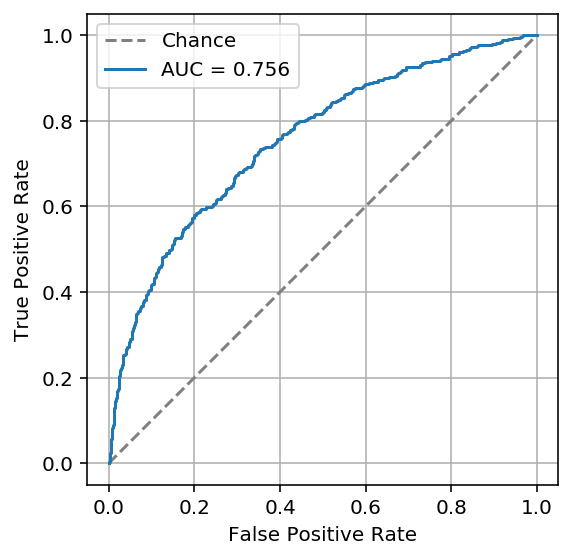

In [122]:
from sklearn.ensemble import GradientBoostingClassifier
gbc_ml_cv_hog_original = GradientBoostingClassifier(n_estimators=100,max_depth=100,
                                                    min_samples_leaf=1,min_samples_split=100,max_features=100)

gbc_cv_prediction_scores,auc_cv = cv_performance_assessment(X_hog_full_train, y,5,gbc_ml_cv_hog_original)
plot_roc(y, gbc_cv_prediction_scores)